In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


## Exclusions and Outliers
-- 3 subject sub-5f706a963b6ac2627a4bb3b5 & sub-611c31c77df20ecc6881cc44 reported 0 variance distributions

In [2]:
sub_df=[]
subs=os.listdir('../bids')
for sub in subs:
    #print(sub)
    if sub not in['subjects.tsv','sub-5f706a963b6ac2627a4bb3b5','sub-611c31c77df20ecc6881cc44',
                 'sub-5d8aa95dd06260000179442b']:#reported 0 variance distributions
        mem=pd.read_csv('../bids/%s/%s_mem-report.tsv'%(sub,sub),sep='\t')
        if len(mem.groupby('dist').mean())<2:
            print("didn't answer for all dists",sub)
        else:
            vals=[]
            for dist in ['narrow','wide','skew']:
                vals.append(len(mem[(mem['dist']=='wide')&(mem['value']>0)]))
            if any([val<2 for val in vals]):
                print("non zero std ",sub)
            else:
                mem.percent=mem.percent.astype(int)

                mem['value']=mem['value'].astype(int)
                mem.loc[mem['value'] < 0, 'value'] = 0
                mem=pd.DataFrame(mem.values.repeat(mem.value, axis=0), columns=mem.columns)
                mem.percent=mem.percent.astype(int)
                mem['order']=mem['order'].astype(int)
                mem['value']=mem['value'].astype(int)
                mem=mem[['dist','percent','value','order']]
                O_df=mem.groupby('dist').mean().reset_index()
                order_var=O_df[O_df['dist']=='wide']['order'].values-O_df[O_df['dist']=='narrow']['order'].values
                if len(mem.groupby('dist').mean())>2:
                    mem_df=pd.DataFrame()
                    mem_df['dist']=['narrow','skew','wide']
                    mem_df['narrow_first']=order_var[0]
                    mem_df['means']=mem.groupby('dist').mean()['percent'].values
                    mem_df['stds']=mem.groupby('dist').std()['percent'].values
                    mem_df['skew']=mem.groupby('dist').skew()['percent'].values
                    mem_df['sub']=(sub)
                    sub_df.append(mem_df)
                else:
                    #print(sub)
                    pass
sub_df=pd.concat(sub_df)
sub_df=sub_df.reset_index()

non zero std  sub-5c92870723bd7e001870138e
non zero std  sub-64270a5159f257ca7fb39155
non zero std  sub-5cb34fdb9a26a300017302d8
non zero std  sub-5fa315662ca5b25d05ae8236
non zero std  sub-6428f7ac297e312f7262d93b
non zero std  sub-56c8915edfea6c000cb29c98
non zero std  sub-62897d2024f826ea90b7efa1
non zero std  sub-5dd3eb4bc0823f3d043b96fb
non zero std  sub-62ff26509176c97c9ceebc2b
non zero std  sub-63782709326973c77adc3db8
non zero std  sub-5ec97fd040ce7448f367784b
non zero std  sub-5c8198fcf29fd90001a2b9c9
non zero std  sub-63f2e107c4d0bc684b99d2c6
non zero std  sub-5bdc8d12b2fff7000189b6f8
non zero std  sub-63d4d6434407b2b392e65863
non zero std  sub-637d4793730be3ac44f5a4a5


In [3]:
import statsmodels.api as sm
row=[]
exclude=[]
for sub in sub_df['sub'].unique():
    df=pd.read_csv('../bids/%s/%s_task-amb_run-1_events.tsv'%(sub,sub),
                   sep='\t')
    if any(df[df['choice']=='risk']['per']==0):
        exclude.append(sub)
    elif any(df[df['choice']=='Ambiguity']['per']==1):
        exclude.append(sub)
    
print("Out of %s participants an additional %s were excluded do to choice checks"%(len(
    sub_df['sub'].unique()),len(exclude)))
print("This leaves us with a total of %s"%(len(
    sub_df['sub'].unique())-len(exclude)))
sub_df=sub_df[~sub_df['sub'].isin(exclude)]
df=pd.read_csv('../bids/subjects.tsv',sep='\t')
df=df[df['sub'].isin(sub_df['sub'].values)].reset_index()
sub_df=sub_df.merge(df,left_on='sub',right_on='sub')
sub_df.head()

Out of 285 participants an additional 15 were excluded do to choice checks
This leaves us with a total of 270


,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,AQ_AttnDet,AQ_AttnSwitch,AQ_Commun,AQ_Imagine,AQ_total,age,education,sex,race
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,111,1,2.625,4.125,3.625,3.125,2.625,3.225,44,Bachelor's Degree,Male,White / Caucasian
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2,111,1,2.625,4.125,3.625,3.125,2.625,3.225,44,Bachelor's Degree,Male,White / Caucasian
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,111,1,2.625,4.125,3.625,3.125,2.625,3.225,44,Bachelor's Degree,Male,White / Caucasian
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499,407,1,3.250,4.375,3.250,3.000,2.875,3.350,44,Bachelor's Degree,Male,Black or African American
4,1,skew,-1.0,47.058824,27.102746,-0.458493,sub-5c7e764fa7432a00169e1499,407,1,3.250,4.375,3.250,3.000,2.875,3.350,44,Bachelor's Degree,Male,Black or African American


## Hypothesis 3 a:
- Autistic traits measured by the autism quotient, will be negatively correlated ambiguity aversion. 
- Choice ~ Probability + Autistic Trait 

In [4]:
sub_df[sub_df['sub']==sub][['AQ_Social','AQ_AttnDet','AQ_AttnSwitch','AQ_Commun','AQ_Imagine','AQ_total']].values[0]

array([3.875, 2.375, 4.125, 3.5  , 3.625, 3.5  ])

In [5]:
amb_df=[]
for sub in sub_df['sub'].unique():
    #print(sub)
    amb=pd.read_csv('../bids/%s/%s_task-amb_run-1_events.tsv'%(sub,sub),sep='\t')
    amb['sub']=sub
    amb['order']=sub_df[sub_df['sub']==sub]['narrow_first'].values[0]
    amb[['AQ_Social','AQ_AttnDet','AQ_AttnSwitch','AQ_Commun','AQ_Imagine','AQ_total']]=sub_df[
        sub_df['sub']==sub][
        ['AQ_Social','AQ_AttnDet','AQ_AttnSwitch','AQ_Commun','AQ_Imagine','AQ_total']].values[0]
    
    amb_df.append(amb)
        
amb_df=pd.concat(amb_df)
print("no NA values for choice ",amb_df['choice'].unique())
amb_df['choose_risk']=amb_df['choice']=='risk'
print("no NA values for Amb ",amb_df['Amb'].unique())
amb_df['full_A']=amb_df['Amb']=='[0,1]'
print("no NA values for dist ",amb_df['dist'].unique())
amb_df['wide_dist']=amb_df['dist']=='wide'
print("NA values for percent ",any(amb_df['per'].isna()))


amb_df.head()

no NA values for choice  ['risk' 'Ambiguous']
no NA values for Amb  ['[0.25,0.75]' '[0,1]']
no NA values for dist  ['wide' 'narrow' 'skew']
NA values for percent  False


,Blocktype,tnum,rt,color,per,Amb,choice,dist,side,response,...,order,AQ_Social,AQ_AttnDet,AQ_AttnSwitch,AQ_Commun,AQ_Imagine,AQ_total,choose_risk,full_A,wide_dist
0,Ambiguity,0.0,1666.0,blue,0.50,"[0.25,0.75]",risk,wide,right,j,...,-1.0,2.625,4.125,3.625,3.125,2.625,3.225,True,False,True
1,Ambiguity,1.0,2371.0,blue,0.41,"[0.25,0.75]",Ambiguous,wide,right,f,...,-1.0,2.625,4.125,3.625,3.125,2.625,3.225,False,False,True
2,Ambiguity,2.0,1480.0,blue,0.46,"[0.25,0.75]",risk,wide,left,f,...,-1.0,2.625,4.125,3.625,3.125,2.625,3.225,True,False,True
3,Ambiguity,3.0,1457.0,blue,0.42,"[0.25,0.75]",Ambiguous,wide,right,f,...,-1.0,2.625,4.125,3.625,3.125,2.625,3.225,False,False,True
4,Ambiguity,4.0,1914.0,blue,0.43,"[0.25,0.75]",Ambiguous,wide,right,f,...,-1.0,2.625,4.125,3.625,3.125,2.625,3.225,False,False,True


In [6]:
from pymer4.models import Lmer
model_df=amb_df[amb_df['full_A']==True]

aqs=[aq for aq in model_df.columns if aq.startswith('AQ_')]

for aq in aqs:
    model = Lmer("choose_risk  ~ per+%s  + (1|sub)"%(aq),
                 data=model_df, family = 'binomial')

    display(model.fit(robust='hcl'))


Formula: choose_risk~per+AQ_Social+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 11610	 Groups: {'sub': 258.0}

Log-likelihood: -7538.133 	 AIC: 15084.266

Random effects:

            Name    Var    Std
sub  (Intercept)  0.585  0.765

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-3.021,-3.496,-2.547,0.242,0.049,0.030,0.078,0.046,0.029,0.073,-12.474,0.000,***
per,6.153,5.690,6.616,0.236,470.217,296.018,746.926,0.998,0.997,0.999,26.060,0.000,***
AQ_Social,-0.057,-0.172,0.059,0.059,0.945,0.842,1.060,0.486,0.457,0.515,-0.961,0.336,


Formula: choose_risk~per+AQ_AttnDet+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 11610	 Groups: {'sub': 258.0}

Log-likelihood: -7537.986 	 AIC: 15083.972

Random effects:

            Name    Var    Std
sub  (Intercept)  0.584  0.764

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-3.499,-4.052,-2.946,0.282,0.030,0.017,0.053,0.029,0.017,0.050,-12.400,0.00,***
per,6.156,5.693,6.619,0.236,471.410,296.749,748.873,0.998,0.997,0.999,26.067,0.00,***
AQ_AttnDet,0.072,-0.056,0.200,0.065,1.075,0.946,1.221,0.518,0.486,0.550,1.104,0.27,


Formula: choose_risk~per+AQ_AttnSwitch+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 11610	 Groups: {'sub': 258.0}

Log-likelihood: -7538.591 	 AIC: 15085.181

Random effects:

            Name    Var    Std
sub  (Intercept)  0.587  0.766

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-3.250,-3.897,-2.604,0.330,0.039,0.020,0.074,0.037,0.020,0.069,-9.856,0.000,***
per,6.153,5.690,6.616,0.236,470.058,295.905,746.709,0.998,0.997,0.999,26.056,0.000,***
AQ_AttnSwitch,0.007,-0.147,0.160,0.078,1.007,0.864,1.174,0.502,0.463,0.540,0.086,0.931,


Formula: choose_risk~per+AQ_Commun+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 11610	 Groups: {'sub': 258.0}

Log-likelihood: -7538.377 	 AIC: 15084.755

Random effects:

            Name    Var    Std
sub  (Intercept)  0.586  0.765

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-3.064,-3.595,-2.534,0.271,0.047,0.027,0.079,0.045,0.027,0.073,-11.327,0.00,***
per,6.152,5.689,6.615,0.236,469.760,295.653,746.396,0.998,0.997,0.999,26.042,0.00,***
AQ_Commun,-0.049,-0.195,0.097,0.075,0.952,0.823,1.102,0.488,0.451,0.524,-0.659,0.51,


Formula: choose_risk~per+AQ_Imagine+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 11610	 Groups: {'sub': 258.0}

Log-likelihood: -7538.234 	 AIC: 15084.469

Random effects:

            Name    Var    Std
sub  (Intercept)  0.585  0.765

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-3.013,-3.553,-2.474,0.275,0.049,0.029,0.084,0.047,0.028,0.078,-10.946,0.000,***
per,6.150,5.687,6.613,0.236,468.729,294.935,744.935,0.998,0.997,0.999,26.019,0.000,***
AQ_Imagine,-0.069,-0.229,0.091,0.082,0.933,0.795,1.095,0.483,0.443,0.523,-0.849,0.396,


Formula: choose_risk~per+AQ_total+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 11610	 Groups: {'sub': 258.0}

Log-likelihood: -7538.531 	 AIC: 15085.062

Random effects:

            Name    Var    Std
sub  (Intercept)  0.587  0.766

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-3.097,-3.837,-2.356,0.378,0.045,0.022,0.095,0.043,0.021,0.087,-8.197,0.000,***
per,6.152,5.688,6.615,0.236,469.479,295.423,746.085,0.998,0.997,0.999,26.029,0.000,***
AQ_total,-0.036,-0.236,0.163,0.102,0.964,0.790,1.177,0.491,0.441,0.541,-0.356,0.722,


## Model for H3C

In [8]:
model_df=amb_df[(amb_df['full_A']==True)&(amb_df['dist']=='narrow')]

model = Lmer("choose_risk  ~ per+(1|sub)",
             data=model_df, family = 'binomial')

model.fit(robust='hcl')

fixedEFF_df=model.fixef.reset_index()
fixedEFF_df=fixedEFF_df.rename(columns={'index':'sub'})
sub_df=sub_df.merge(fixedEFF_df[['sub','(Intercept)']],on='sub')
sub_df.head()

Formula: choose_risk~per+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2356.495 	 AIC: 4718.990

Random effects:

            Name     Var    Std
sub  (Intercept)  10.807  3.287

No random effect correlations specified

Fixed effects:



,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,AQ_AttnDet,AQ_AttnSwitch,AQ_Commun,AQ_Imagine,AQ_total,age,education,sex,race,(Intercept)
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,111,1,2.625,4.125,3.625,3.125,2.625,3.225,44,Bachelor's Degree,Male,White / Caucasian,-12.406517
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2,111,1,2.625,4.125,3.625,3.125,2.625,3.225,44,Bachelor's Degree,Male,White / Caucasian,-12.406517
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,111,1,2.625,4.125,3.625,3.125,2.625,3.225,44,Bachelor's Degree,Male,White / Caucasian,-12.406517
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499,407,1,3.250,4.375,3.250,3.000,2.875,3.350,44,Bachelor's Degree,Male,Black or African American,-12.118511
4,1,skew,-1.0,47.058824,27.102746,-0.458493,sub-5c7e764fa7432a00169e1499,407,1,3.250,4.375,3.250,3.000,2.875,3.350,44,Bachelor's Degree,Male,Black or African American,-12.118511


## Hypothesis 3 b:
- Autistic traits will be negatively correlated with the variance of individual’s reported belief about the distribution of probabilities.

In [9]:
sub_df[sub_df['dist'].isin(['narrow','wide'])]

,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,AQ_AttnDet,AQ_AttnSwitch,AQ_Commun,AQ_Imagine,AQ_total,age,education,sex,race,(Intercept)
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,111,1,2.625,4.125,3.625,3.125,2.625,3.225,44,Bachelor's Degree,Male,White / Caucasian,-12.406517
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,111,1,2.625,4.125,3.625,3.125,2.625,3.225,44,Bachelor's Degree,Male,White / Caucasian,-12.406517
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499,407,1,3.250,4.375,3.250,3.000,2.875,3.350,44,Bachelor's Degree,Male,Black or African American,-12.118511
5,2,wide,-1.0,50.625000,33.159966,-0.150303,sub-5c7e764fa7432a00169e1499,407,1,3.250,4.375,3.250,3.000,2.875,3.350,44,Bachelor's Degree,Male,Black or African American,-12.118511
6,0,narrow,2.0,29.047619,19.469145,0.237221,sub-5fb16308dc5973607fa3041c,51,4,4.000,3.250,3.500,3.625,3.375,3.550,59,"High school graduate, diploma or the equivalent",Female,White / Caucasian,-10.019545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370,2,wide,-1.0,50.000000,32.366944,0.000000,sub-5fea025ffeba314a5f1fbda8,414,1,2.625,3.125,4.000,3.625,2.750,3.225,21,Bachelor's Degree,Male,White / Caucasian,-12.473906
1371,0,narrow,1.0,51.538462,36.601586,-0.068506,sub-614fca8245a450546842e487,30,1,3.875,2.375,4.125,3.500,3.625,3.500,62,Associates Degree,Female,White / Caucasian,-12.421805
1372,0,narrow,1.0,51.538462,36.601586,-0.068506,sub-614fca8245a450546842e487,503,1,3.875,2.375,4.125,3.500,3.625,3.500,62,Associates Degree,Female,White / Caucasian,-12.421805
1375,2,wide,1.0,47.600000,15.620499,-0.136547,sub-614fca8245a450546842e487,30,1,3.875,2.375,4.125,3.500,3.625,3.500,62,Associates Degree,Female,White / Caucasian,-12.421805


In [10]:
sub_df

,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,AQ_AttnDet,AQ_AttnSwitch,AQ_Commun,AQ_Imagine,AQ_total,age,education,sex,race,(Intercept)
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,111,1,2.625,4.125,3.625,3.125,2.625,3.225,44,Bachelor's Degree,Male,White / Caucasian,-12.406517
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2,111,1,2.625,4.125,3.625,3.125,2.625,3.225,44,Bachelor's Degree,Male,White / Caucasian,-12.406517
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,111,1,2.625,4.125,3.625,3.125,2.625,3.225,44,Bachelor's Degree,Male,White / Caucasian,-12.406517
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499,407,1,3.250,4.375,3.250,3.000,2.875,3.350,44,Bachelor's Degree,Male,Black or African American,-12.118511
4,1,skew,-1.0,47.058824,27.102746,-0.458493,sub-5c7e764fa7432a00169e1499,407,1,3.250,4.375,3.250,3.000,2.875,3.350,44,Bachelor's Degree,Male,Black or African American,-12.118511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,0,narrow,1.0,51.538462,36.601586,-0.068506,sub-614fca8245a450546842e487,503,1,3.875,2.375,4.125,3.500,3.625,3.500,62,Associates Degree,Female,White / Caucasian,-12.421805
1373,1,skew,1.0,68.947368,22.581885,-1.439625,sub-614fca8245a450546842e487,30,1,3.875,2.375,4.125,3.500,3.625,3.500,62,Associates Degree,Female,White / Caucasian,-12.421805
1374,1,skew,1.0,68.947368,22.581885,-1.439625,sub-614fca8245a450546842e487,503,1,3.875,2.375,4.125,3.500,3.625,3.500,62,Associates Degree,Female,White / Caucasian,-12.421805
1375,2,wide,1.0,47.600000,15.620499,-0.136547,sub-614fca8245a450546842e487,30,1,3.875,2.375,4.125,3.500,3.625,3.500,62,Associates Degree,Female,White / Caucasian,-12.421805


NEW DIST narrow 

AQ_Social
Normality AQ Statistics=0.990, p=0.086
Normality stds Statistics=0.974, p=0.000
R: -0.12261534823856943 P: 0.00398803189154634


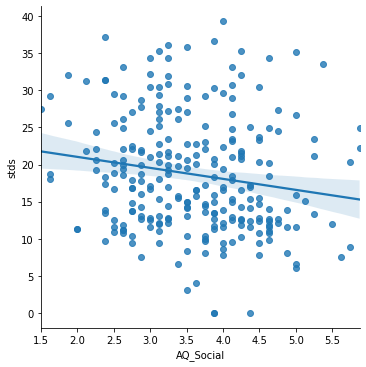

AQ_AttnDet
Normality AQ Statistics=0.985, p=0.010
Normality stds Statistics=0.974, p=0.000
R: 0.014748219829663048 P: 0.7296937290353149


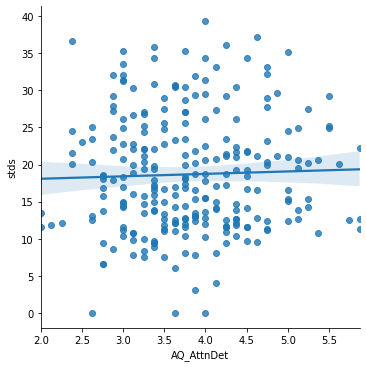

AQ_AttnSwitch
Normality AQ Statistics=0.986, p=0.015
Normality stds Statistics=0.974, p=0.000
R: -0.10843726299078202 P: 0.011560613687579742


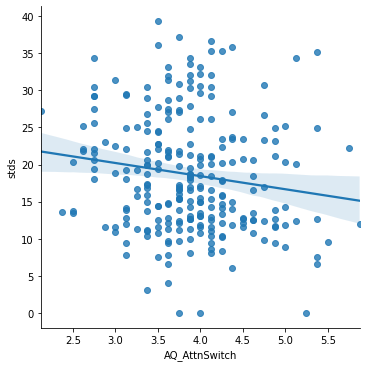

AQ_Commun
Normality AQ Statistics=0.989, p=0.053
Normality stds Statistics=0.974, p=0.000
R: -0.1326960036613422 P: 0.0019307961952573273


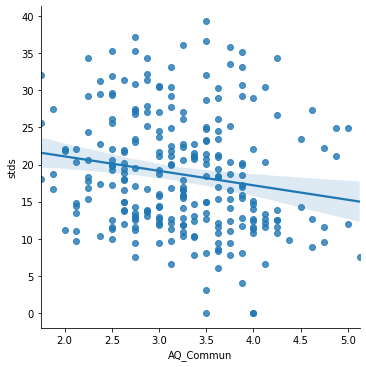

AQ_Imagine
Normality AQ Statistics=0.984, p=0.006
Normality stds Statistics=0.974, p=0.000
R: -0.061893373571990276 P: 0.14900700984902815


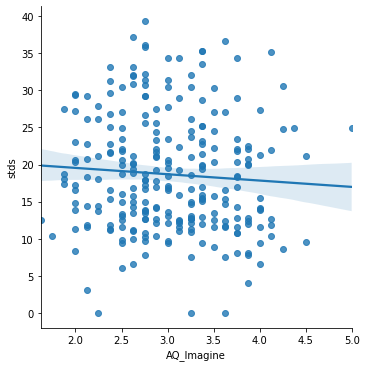

AQ_total
Normality AQ Statistics=0.986, p=0.011
Normality stds Statistics=0.974, p=0.000
R: -0.12731091744784775 P: 0.0024619909900458125


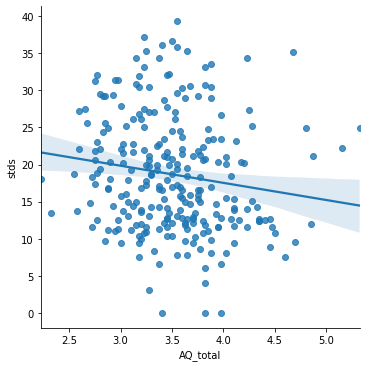

NEW DIST skew 

AQ_Social
Normality AQ Statistics=0.990, p=0.086
Normality stds Statistics=0.983, p=0.004
R: -0.02606295931092844 P: 0.5404736813405833


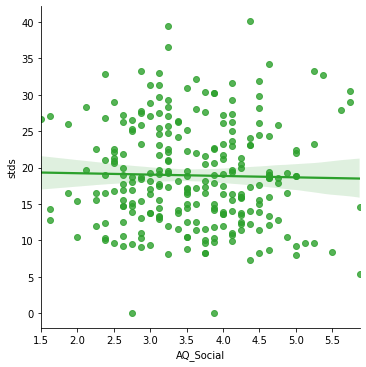

AQ_AttnDet
Normality AQ Statistics=0.985, p=0.010
Normality stds Statistics=0.983, p=0.004
R: -0.0037942996583059125 P: 0.9291510958838365


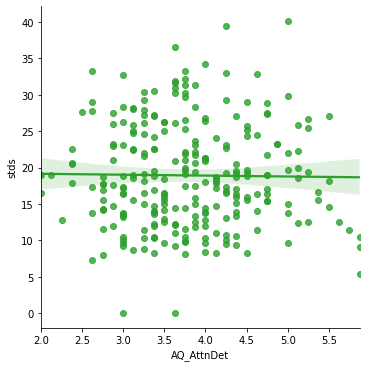

AQ_AttnSwitch
Normality AQ Statistics=0.986, p=0.015
Normality stds Statistics=0.983, p=0.004
R: -0.08673279536466144 P: 0.0433609751898032


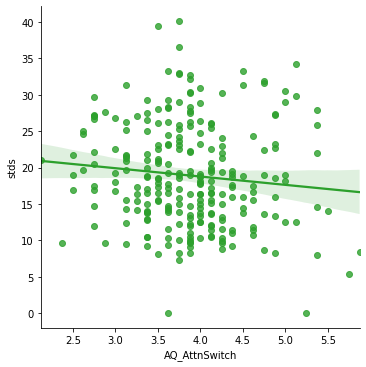

AQ_Commun
Normality AQ Statistics=0.989, p=0.053
Normality stds Statistics=0.983, p=0.004
R: -0.04019083485292136 P: 0.3475715275890765


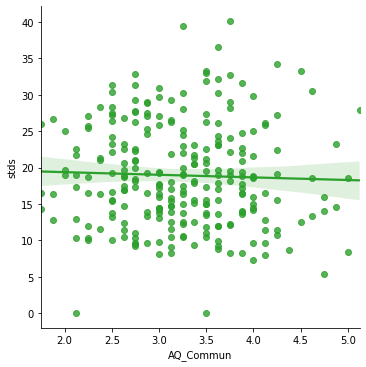

AQ_Imagine
Normality AQ Statistics=0.984, p=0.006
Normality stds Statistics=0.983, p=0.004
R: 0.05651509177833433 P: 0.18753506431003275


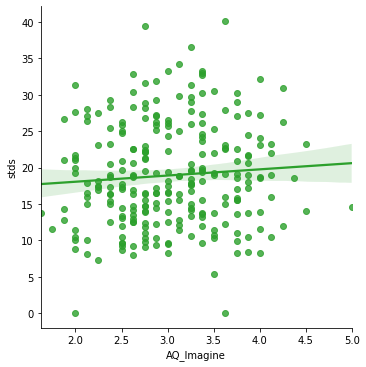

AQ_total
Normality AQ Statistics=0.986, p=0.011
Normality stds Statistics=0.983, p=0.004
R: -0.03268644842761285 P: 0.4368244565854087


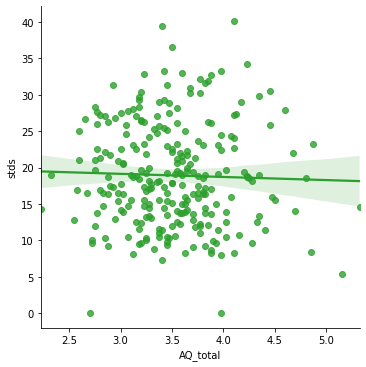

NEW DIST wide 

AQ_Social
Normality AQ Statistics=0.990, p=0.086
Normality stds Statistics=0.963, p=0.000
R: 0.01944604060378937 P: 0.6478698406142173


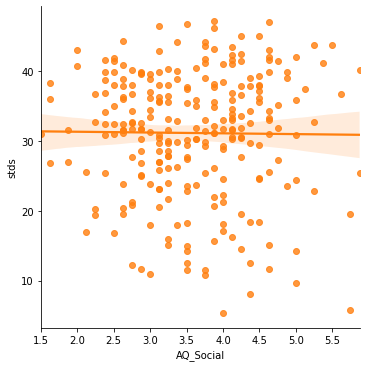

AQ_AttnDet
Normality AQ Statistics=0.985, p=0.010
Normality stds Statistics=0.963, p=0.000
R: 0.07659087465049617 P: 0.07267237701473955


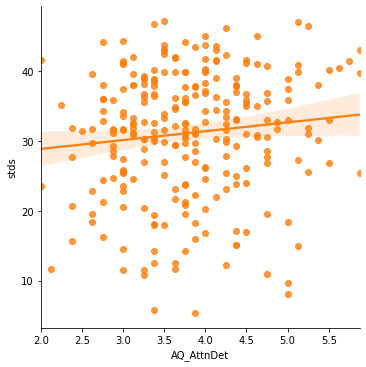

AQ_AttnSwitch
Normality AQ Statistics=0.986, p=0.015
Normality stds Statistics=0.963, p=0.000
R: 0.052496267820641034 P: 0.22139121751966073


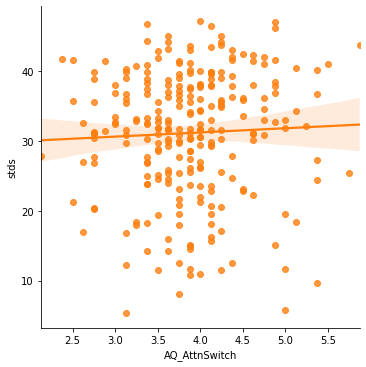

AQ_Commun
Normality AQ Statistics=0.989, p=0.053
Normality stds Statistics=0.963, p=0.000
R: 0.08145964814059742 P: 0.05691973530072515


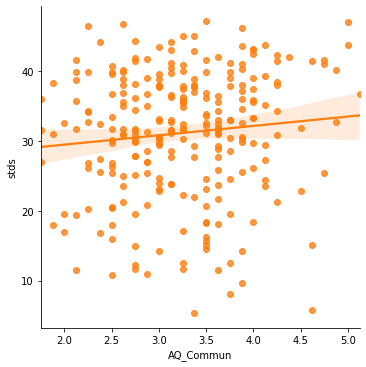

AQ_Imagine
Normality AQ Statistics=0.984, p=0.006
Normality stds Statistics=0.963, p=0.000
R: 0.05055655388826335 P: 0.23838800551594286


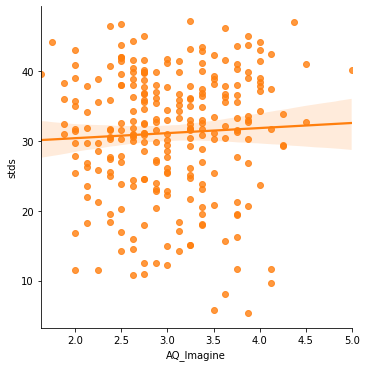

AQ_total
Normality AQ Statistics=0.986, p=0.011
Normality stds Statistics=0.963, p=0.000
R: 0.08755312322342029 P: 0.03726083611048124


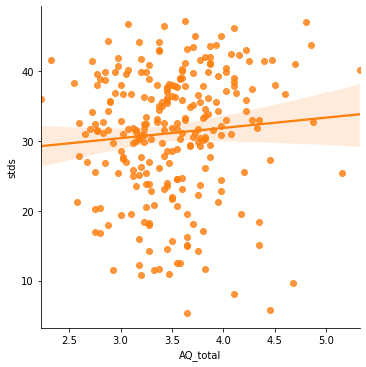

In [12]:
from scipy.stats import pearsonr, spearmanr, kendalltau, zscore, shapiro

for dist in sub_df['dist'].unique():
    if dist=='narrow':
        color=[plt.cm.tab10(0)]
    if dist=='wide':
        color=[plt.cm.tab10(1)]
    if dist=='skew':
        color=[plt.cm.tab10(2)]
    print('NEW DIST', dist, '\n')
    plt_df=sub_df[sub_df['dist'].isin([dist])]
    plt_df=plt_df.groupby(by='sub').mean()
    for aq in [aq for aq in df.columns if aq.startswith('AQ_')]:
        print(aq)
        stat, p = shapiro(plt_df[aq])
        print('Normality AQ Statistics=%.3f, p=%.3f' % (stat, p))
        stat, p = shapiro(plt_df['stds'])
        print('Normality stds Statistics=%.3f, p=%.3f' % (stat, p))
        r,p=kendalltau(plt_df[aq],plt_df['stds'])
        print("R: %s P: %s"%(r,p))
        sns.lmplot(x=aq,y='stds',data=plt_df,order=1,
                   line_kws={'color': color[0]}, scatter_kws={'color': color})
        plt.show()

## Hypothesis 3 c:
- Variance of an individual’s reported belief about the probabilities mediates the relationship between autistic traits and ambiguity aversion.  

In [ ]:
from pingouin import mediation_analysis, read_dataset

model_df=sub_df[sub_df['dist'].isin(['narrow'])]
model_df=model_df.groupby(by='sub').mean()

mediation_analysis(data=model_df, x='AQ_total', m='stds', y='(Intercept)', alpha=0.05,

                   seed=42)

In [ ]:
model_df['AQ_cut']=model_df>3